## 수식없이도 이해할 수 있는 chat gpt와 stable diffusion

## 1. chat GPt를 이용하여 프롬프트 만들기

#### - 입력값 : 'Building in the old Village.'

In [1]:
# Created with AIPRM Prompt "Stable Diffusion Prompt based on your Idea"

# Detailed Prompt:
# (Subject) A majestic, mythical phoenix,
# (Action) soaring gracefully through the skies,
# (Context) above a lush, enchanted forest,
# (Environment) bathed in the warm, golden hues of a setting sun,
# (Lighting) casting long, ethereal shadows,
# (Artist) reminiscent of the works of Gustav Klimt,
# (Style) with intricate, swirling patterns and ornate details,
# (Medium) on a canvas stretched across a grand easel,
# (Type) in a Renaissance-inspired masterpiece,
# (Color Scheme) featuring rich, deep reds, shimmering golds, and deep emeralds,
# (Computer Graphics) with a touch of digital magic to enhance the brilliance,
# (Quality) ensuring the highest level of detail and realism.

# Positive Prompt: Phoenix in majestic flight, enchanted forest, warm sunset, Klimt-inspired, highly detailed, Renaissance masterpiece, rich color palette, digitally enhanced.

# Negative Prompts: blurry, pixelated, poorly drawn feathers, unnatural colors, pixelation, bad composition, distorted proportions, low-resolution, excessive noise, overly simplistic, excessive filters, incorrect anatomy, oversaturation, out of frame.

## 2. 하이퍼 파라미터를 조절하여 윤곽선 검출 조건 생성

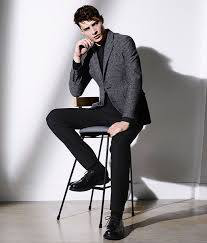

In [2]:
# Q. 코드를 작성해 보세요.
# 이미지를 불러오세요. 
image_path = '/aiffel/aiffel/diffusers/image_4.jpg'

canny_image4 = load_image(image_path)
canny_image4

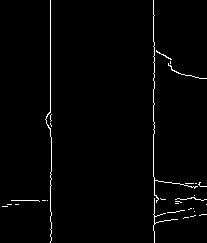

In [3]:
from diffusers.utils import load_image 
from PIL import Image
import cv2
import numpy as np
import matplotlib as plt
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)
# #threshhold를 지정합니다. 
low_threshold = 200
high_threshold = 200

# # 이미지를 NumPy 배열로 변환합니다. 
canny_image4 = np.array(canny_image4)

# # 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다. 
zero_start = canny_image4.shape[1] // 4
zero_end = zero_start + canny_image4.shape[1] // 2
canny_image4[:, zero_start:zero_end] = 0

# # 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다. 
canny_image4 = cv2.Canny(canny_image4, low_threshold, high_threshold)
canny_image4 = canny_image4[:,:, None]
canny_image4 = np.concatenate([canny_image4, canny_image4, canny_image4], axis = 2)
canny_image4 = Image.fromarray(canny_image4)
canny_image4

## 3. 인체 자세 검출 전처리기를 사용하여 이미지 생성

In [5]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
# Openpose 전처리기를 사용한 모델 파이프라인을 불러오기
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel 

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

cuda


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


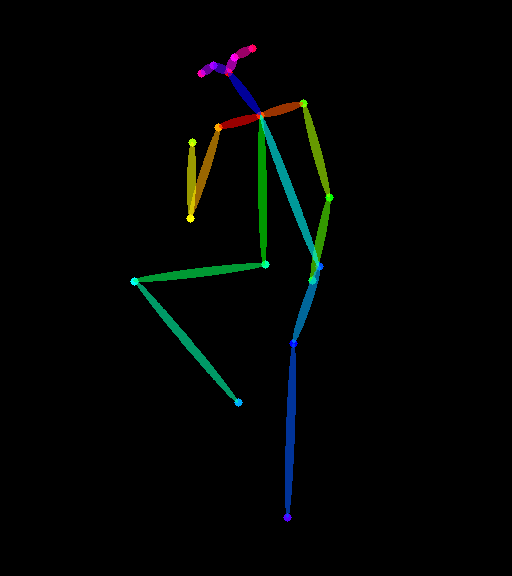

In [9]:
# 이미지를 불러옵니다. 
image_path2 = '/aiffel/aiffel/diffusers/image_4.jpg'

openpose_image2 = load_image(image_path2)
openpose_image2

# OpenposeDetector를 사용하여 인체 자세를 검출합니다. 
openpose_image2 = openpose(openpose_image2)
openpose_image2

## 4.   윤곽선 검출 전처리기와 Openpose 전처리기를 같이 사용하여 이미지 생성

In [12]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler  

# Q. 코드를 작성해 보세요.
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다. 
controlnets = [canny_controlnet, openpose_controlnet]
pipeline_settings = {
    'controlnet': controlnets}  # 'controlnet' 모듈을 설정에 추가합니다.


# 리스트 controlnets를 파이프라인으로 전달합니다. 
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnets=controlnets, torch_dtype=torch.float16
)


pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다. 
prompt =  "Please create a beautiful space landscape."
negative_prompt =  "Please draw a space landscape that is not dark or scary"
# seed를 지정합니다. 
generator = [42]

images = [openpose_image, canny_image]

# 이미지를 생성합니다. 
image = pipe(prompt=prompt, negative_prompt=negative_prompt, generator=generator, image=images).images[0]

# 생성된 이미지를 저장합니다.
image.save("aiffel/aiffel/multi_controlnet_output.png")

# 생성된 이미지를 출력합니다.  
image

Keyword arguments {'controlnets': [ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2,

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


ValueError: Pipeline <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> expected {'controlnet', 'safety_checker', 'unet', 'feature_extractor', 'tokenizer', 'scheduler', 'vae', 'text_encoder'}, but only {'safety_checker', 'unet', 'feature_extractor', 'tokenizer', 'scheduler', 'vae', 'text_encoder'} were passed.

#### Controlnet 모델을 파이프라인에 올려서 설정을 해야하는데.. 계속 모델을 불러오는 방법만 이용하다 주어진 조건을 붙이는 방법은 찾지 못해 수정을 못하였다.

회고 : 직접 이미지를 가지고 파이프라인을 받아 진행 한 부분은 좋았다.
    그러나 배우지 않았던 파이토치를 쓰다보니 기본적인 설명이 없어 아쉬웠고,
    커널에 이미 있던 코드 사이에 오류가 있어 아쉬웠다.